In [2]:
print("hello world")

hello world


## Retrieve data from paper

The data for the paper is [here](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE197215)

Get the data:

```
wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE197nnn/GSE197215/suppl/GSE197215%5FIntegrated%5Fobject%5Fof%5FCD19%5F3T3%5Fcondition.rds.gz && gunzip GSE197215_Integrated_object_of_CD19_3T3_condition.rds.gz	

wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE197nnn/GSE197215/suppl/GSE197215%5FIntegrated%5Fobject%5Fof%5FCD3%5FCD28%5Fbeads%5Fcondition.rds.gz && gunzip GSE197215_Integrated_object_of_CD3_CD28_beads_condition.rds.gz	

wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE197nnn/GSE197215/suppl/GSE197215%5FIntegrated%5Fobject%5Fof%5Fmesothelin%5F3T3%5Fcondition.rds.gz && gunzip GSE197215_Integrated_object_of_mesothelin_3T3_condition.rds.gz	

wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE197nnn/GSE197215/suppl/GSE197215%5FIntegrated%5Fobject%5Fof%5Funstimulated%5Fcondition.rds.gz && GSE197215_Integrated_object_of_unstimulated_condition.rds.gz	
```

## Convert from Seurat to h5ad

The data pulled in the previous step are Seurat objects. We need to convert them to h5ad. The [script](https://github.com/indapa/CART19_scRNAseq/blob/master/RScripts/seuratToh5ad.R) here will do the conversion and write out the h5ad file. 

## Install CellXGene and scVI tools

Following the instructions for [embeddings vector search tutorial](https://chanzuckerberg.github.io/cellxgene-census/notebooks/api_demo/census_embedding_search.html?utm_content=303437580&utm_medium=social&utm_source=linkedin&hss_channel=lcp-11301003) from [CellXGene](https://chanzuckerberg.github.io/cellxgene-census), let's install the packages we need.

TODO: update Dockerfile to install these packages, so it's already in the dev environment

In [3]:
#! pip install --upgrade  'cellxgene_census[experimental]' scvi-tools

In [4]:
import warnings

warnings.filterwarnings("ignore")

import anndata
import cellxgene_census.experimental
import cellxgene_census
import pandas as pd
import scanpy as sc
import scvi

CENSUS_VERSION = "2024-07-01"

In [5]:
from pathlib import Path

data_dir = Path("/workspaces/CART19_scRNAseq/Data/AnnDataObjs")

unstimulated_file = data_dir / "GSE197215_Integrated_object_of_unstimulated_condition.h5ad"
mlsn_file = data_dir / "GSE197215_Integrated_object_of_mesothelin_3T3_condition.h5ad"
tcr_file = data_dir / "GSE197215_Integrated_object_of_CD3_CD28_beads_condition.h5ad"
cd19_3T3_file = data_dir / "GSE197215_Integrated_object_of_CD19_3T3_condition.h5ad"

In [6]:
# load the unstimulated data h5ad file into anndata object

print(unstimulated_file)

/workspaces/CART19_scRNAseq/Data/AnnDataObjs/GSE197215_Integrated_object_of_unstimulated_condition.h5ad


In [7]:
#read in all the files

adata_unstimulated = anndata.read_h5ad(unstimulated_file)
adata_mlsn = anndata.read_h5ad(mlsn_file)
adata_tcr = anndata.read_h5ad(tcr_file)
adata_cd19_3T3 = anndata.read_h5ad(cd19_3T3_file)



In [8]:
#add the condition to the adata object

adata_unstimulated.obs["condition"] = "unstimulated"
adata_mlsn.obs["condition"] = "mesothelin_3T3"
adata_tcr.obs["condition"] = "CD3_CD28_beads"
adata_cd19_3T3.obs["condition"] = "CD19_3T3"

#concatenate the adata objects




adatas = {"unstimulated":adata_unstimulated,
            "adata_mlsn": adata_mlsn, 
            "adata_tcr": adata_tcr,
            "adata_cd19_3T3": adata_cd19_3T3}


adata = sc.concat(adatas, join="outer", label="set", index_unique="-")

In [9]:
# I was losing the var layer when concatenating the AnnData objects.
# grab all var DataFrames from our dictionary
# based on this post https://discourse.scverse.org/t/loosing-anndata-var-layer-when-using-sc-concat/1605/2

all_var = [x.var for x in adatas.values()]
# concatenate them
all_var = pd.concat(all_var, join="outer")
# remove duplicates
all_var = all_var[~all_var.index.duplicated()]

In [10]:
all_var

,features
h-TAOK1,h-TAOK1
h-GNLY,h-GNLY
h-TUBA1B,h-TUBA1B
h-HMGB2,h-HMGB2
h-TOP2A,h-TOP2A
...,...
h-ATP5F1A,h-ATP5F1A
h-BTG3,h-BTG3
h-PDZD8,h-PDZD8
h-DNAJB5,h-DNAJB5


In [11]:
adata.var = all_var.loc[adata.var_names]


In [12]:
adata

AnnData object with n_obs × n_vars = 101326 × 3743
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'nCount_ADT_renorm', 'nFeature_ADT_renorm', 'condition', 'set'
    var: 'features'
    obsm: 'X_pca', 'X_umap'

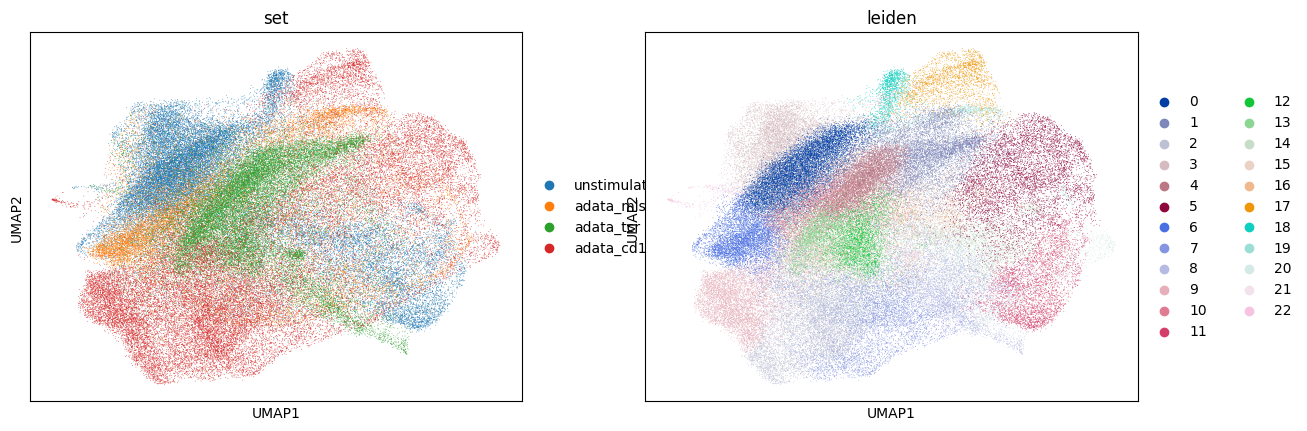

In [13]:
import scanpy as sc
import numpy as np

# Recompute PCA
adata = adata[:, ~np.isnan(adata.X).any(axis=0)]

sc.pp.pca(adata)

# Recompute UMAP
sc.pp.neighbors(adata)
sc.tl.umap(adata)

# Optionally, perform clustering (e.g., Leiden)
sc.tl.leiden(adata)

# Visualize UMAP with clusters or batch/condition labels
sc.pl.umap(adata, color=['set', 'leiden'])


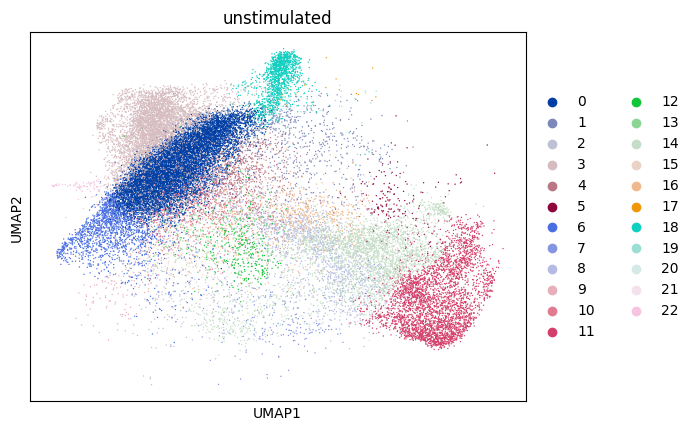

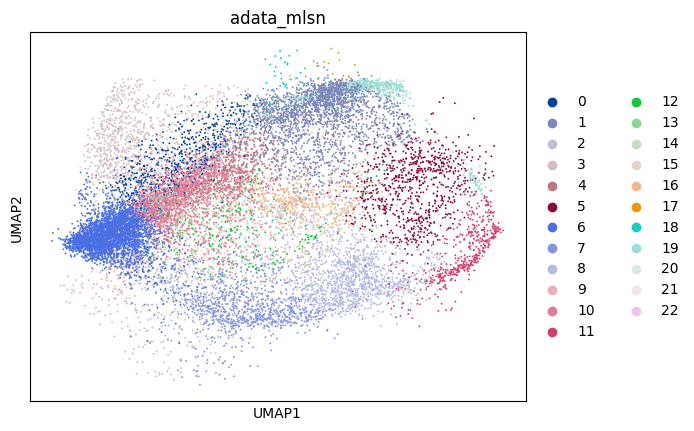

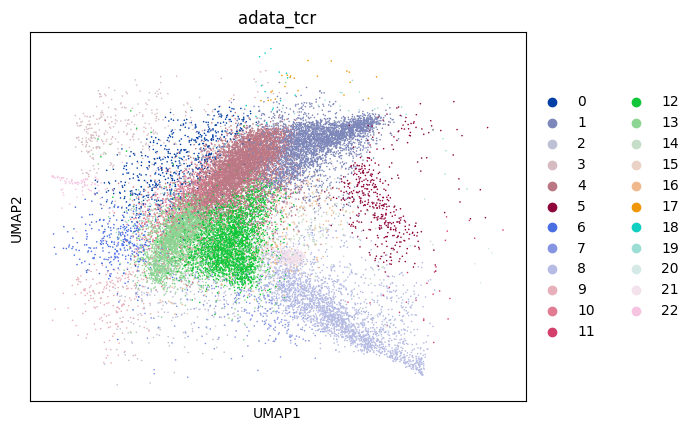

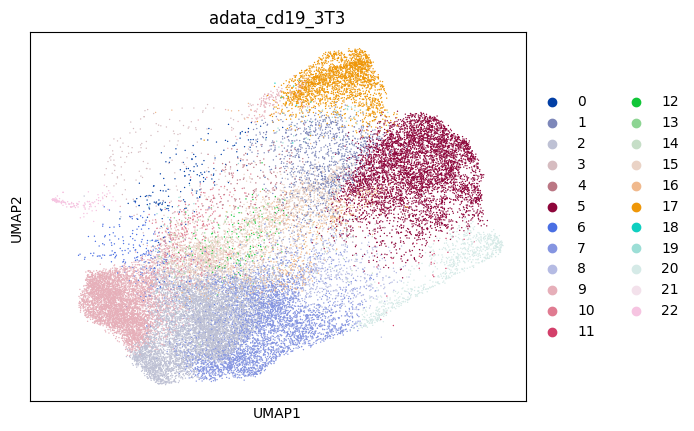

In [14]:
for key in adata.obs.set.unique():
    sc.pl.umap(adata[adata.obs.set == key], color=['leiden'], title=key)

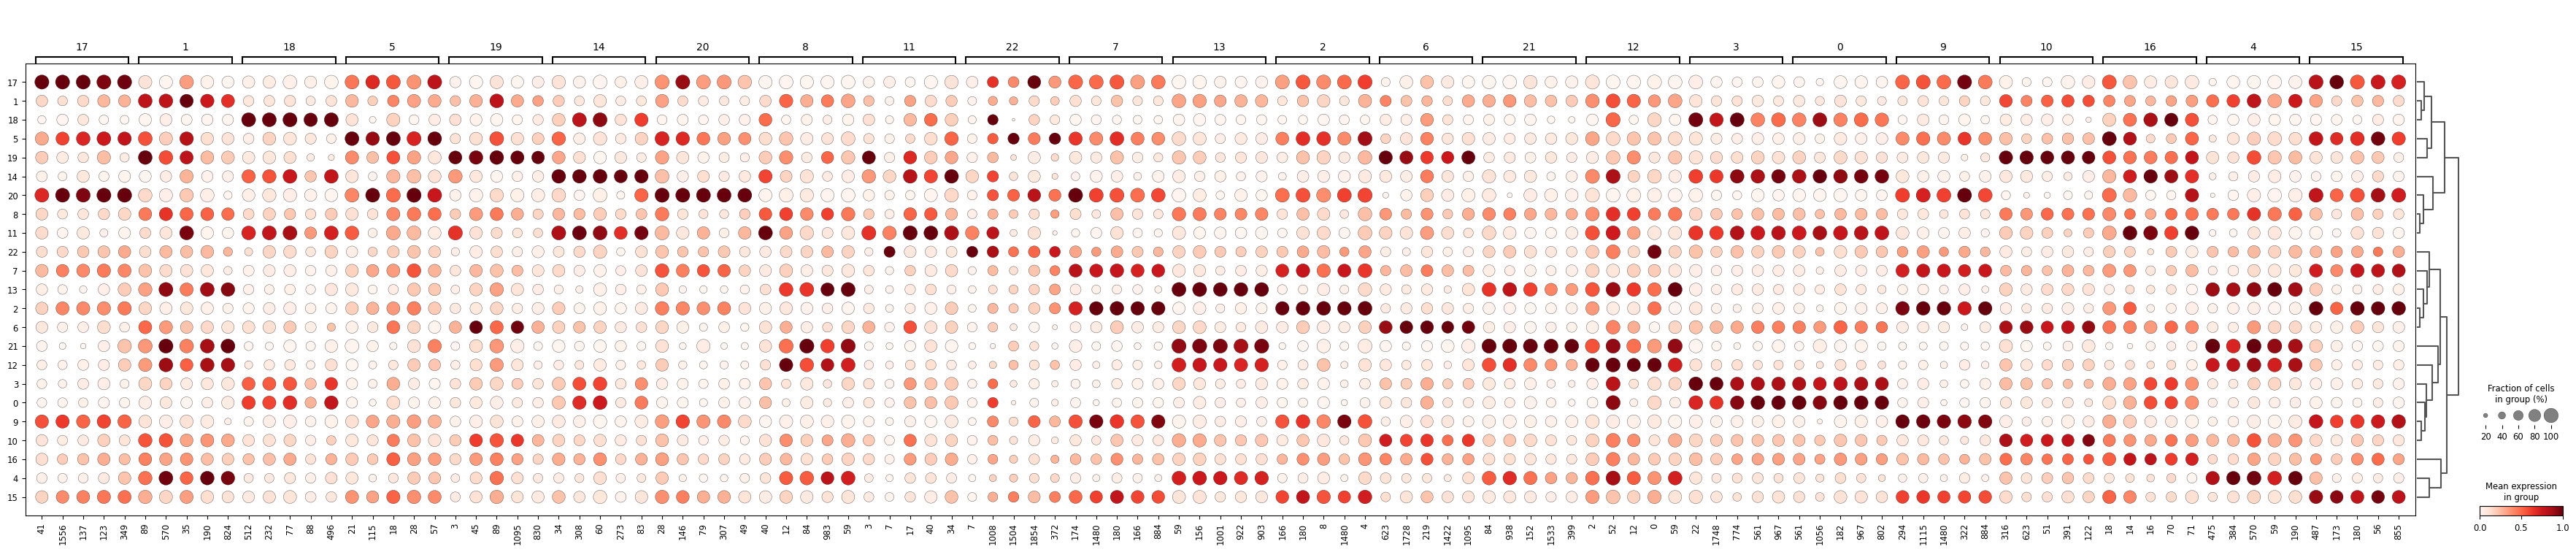

In [16]:
sc.tl.rank_genes_groups(
    adata, groupby="leiden", method="wilcoxon", key_added="dea_leiden"
)

sc.pl.rank_genes_groups_dotplot(
    adata, groupby="leiden", standard_scale="var", n_genes=5, key="dea_leiden")

In [17]:
adata.var_names

Index(['h-ABCF1', 'h-AC004585.1', 'h-AC012360.3', 'h-AC013264.1',
       'h-AC027290.2', 'h-AC027644.3', 'h-AC074032.1', 'h-AC097376.2',
       'h-ACAP2', 'h-ACAT2',
       ...
       'h-ZNF512B', 'h-ZNF518A', 'h-ZNF605', 'h-ZNF638', 'h-ZNHIT6',
       'h-ZRANB2', 'h-ZRSR2', 'h-ZUP1', 'h-ZWILCH', 'h-ZWINT'],
      dtype='object', length=850)